In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json here


Saving Titanic_train.csv to Titanic_train (1).csv


{'Titanic_train (1).csv': b'PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked\r\n1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S\r\n2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C\r\n3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S\r\n4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S\r\n5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S\r\n6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q\r\n7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S\r\n8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S\r\n9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S\r\n10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C\r\n11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S\r\n12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c titanic
!unzip titanic.zip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
unzip:  cannot find or open titanic.zip, titanic.zip.zip or titanic.zip.ZIP.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle


In [ ]:
df = pd.read_csv("Titanic_train.csv")
display(df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Check missing values
print(df.isnull().sum())

# Fill missing Age with median
df['Age'].fillna(df['Age'].median(), inplace=True)

# Fill Embarked with mode
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop Cabin (too many missing values)
df.drop(columns=['Cabin'], inplace=True)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


/tmp/ipython-input-8-1787075645.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-8-1787075645.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

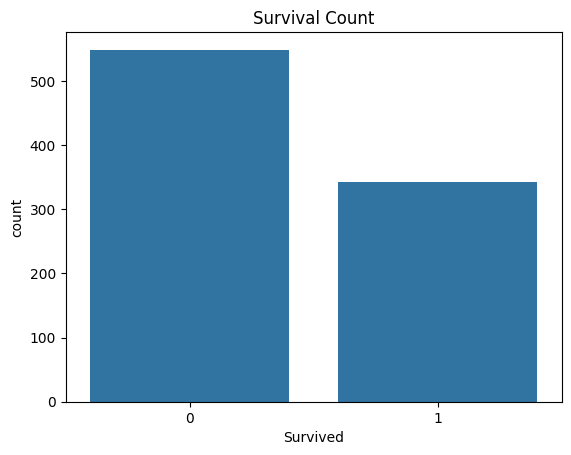

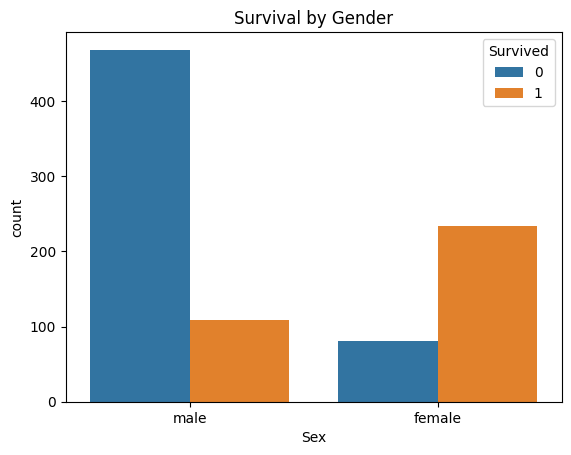

In [ ]:
# Survival Count
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()

# Survival by Gender
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Gender")
plt.show()

# Age Distribution (Interactive)
px.histogram(df, x="Age", color="Survived", nbins=30, title="Age Distribution by Survival")


In [ ]:
# Extract Title from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Simplify titles
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Drop unnecessary columns
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)


In [ ]:
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])        # male:1, female:0
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])


In [ ]:
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))


Logistic Regression Accuracy: 0.8100558659217877
Random Forest Accuracy: 0.8212290502793296


In [ ]:
lr_scores = cross_val_score(lr, X, y, cv=5)
rf_scores = cross_val_score(rf, X, y, cv=5)

print("LR CV Accuracy:", lr_scores.mean())
print("RF CV Accuracy:", rf_scores.mean())


LR CV Accuracy: 0.7923859142552256
RF CV Accuracy: 0.8103508882053857


In [ ]:
# Save Random Forest model (assuming it’s better)
with open("model.pkl", "wb") as f:
    pickle.dump(rf, f)

# Download it
from google.colab import files
files.download("model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>